# Kidney simulation

In [39]:
!nnUNet_predict -i nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task105_KD1/imagesTs -o nnUNet/nnunet/nnUNet_Prediction_Results/Task105_KD1 -t 105 -tr nnUNetTrainerV2_Loss_Dice_Soft -m 2d --save_npz --overwrite_existing


Please cite the following paper when using nnUNet:
Fabian Isensee, Paul F. Jäger, Simon A. A. Kohl, Jens Petersen, Klaus H. Maier-Hein "Automated Design of Deep Learning Methods for Biomedical Image Segmentation" arXiv preprint arXiv:1904.08128 (2020).
If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

using model stored in  /home/mzukovec/Documents/Faks/Semester 3/AMS/nnUNet/nnunet/nnUNet_trained_models/nnUNet/2d/Task105_KD1/nnUNetTrainerV2_Loss_Dice_Soft__nnUNetPlansv2.1
This model expects 1 input modalities for each image
Found 4 unique case ids, here are some examples: ['case24' 'case21' 'case22' 'case23']
If they don't look right, make sure to double check your filenames. They must end with _0000.nii.gz etc
emptying cuda cache
loading parameters for folds, None
folds is None so we will automatically look for output folders (not using 'all'!)
found the following folds:  ['/home/mzukovec/Documents/Faks/Semester 3/AMS/nnUNet/nnune

In [40]:
!nnUNet_predict -i nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task105_KD1/testing -o nnUNet/nnunet/nnUNet_Prediction_Results/Task105_KD1 -t 105 -tr nnUNetTrainerV2_Loss_Dice_Soft -m 2d --save_npz --overwrite_existing


Please cite the following paper when using nnUNet:
Fabian Isensee, Paul F. Jäger, Simon A. A. Kohl, Jens Petersen, Klaus H. Maier-Hein "Automated Design of Deep Learning Methods for Biomedical Image Segmentation" arXiv preprint arXiv:1904.08128 (2020).
If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

using model stored in  /home/mzukovec/Documents/Faks/Semester 3/AMS/nnUNet/nnunet/nnUNet_trained_models/nnUNet/2d/Task105_KD1/nnUNetTrainerV2_Loss_Dice_Soft__nnUNetPlansv2.1
This model expects 1 input modalities for each image
Found 4 unique case ids, here are some examples: ['case28' 'case28' 'case28' 'case25']
If they don't look right, make sure to double check your filenames. They must end with _0000.nii.gz etc
emptying cuda cache
loading parameters for folds, None
folds is None so we will automatically look for output folders (not using 'all'!)
found the following folds:  ['/home/mzukovec/Documents/Faks/Semester 3/AMS/nnUNet/nnune

In [1]:
%matplotlib notebook
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os

def getAverage(path):
    paths = os.listdir(path)
    tmp = []
    for pt in paths:
        if 'task' in pt:
            tmp.append(pt)
    tmp2 = sitk.ReadImage(os.path.join(path, tmp[0]))
    for i in range(1, len(tmp)):
        tmp2 += sitk.ReadImage(os.path.join(path, tmp[i]))
    return sitk.GetArrayFromImage(tmp2)/3.0

In [2]:
src = sitk.ReadImage('/home/mzukovec/Documents/Faks/Semester 3/AMS/nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task105_KD1/imagesTs/case21_0000.nii.gz')
seg = sitk.ReadImage('/home/mzukovec/Documents/Faks/Semester 3/AMS/nnUNet/nnunet/nnUNet_Prediction_Results/Task105_KD1/case21.nii.gz')
data = np.load('/home/mzukovec/Documents/Faks/Semester 3/AMS/nnUNet/nnunet/nnUNet_Prediction_Results/Task105_KD1/case21.npz')
ground_truth = getAverage('Data/validation_data_v2/kidney/Validation/case21')

<IPython.core.display.Javascript object>


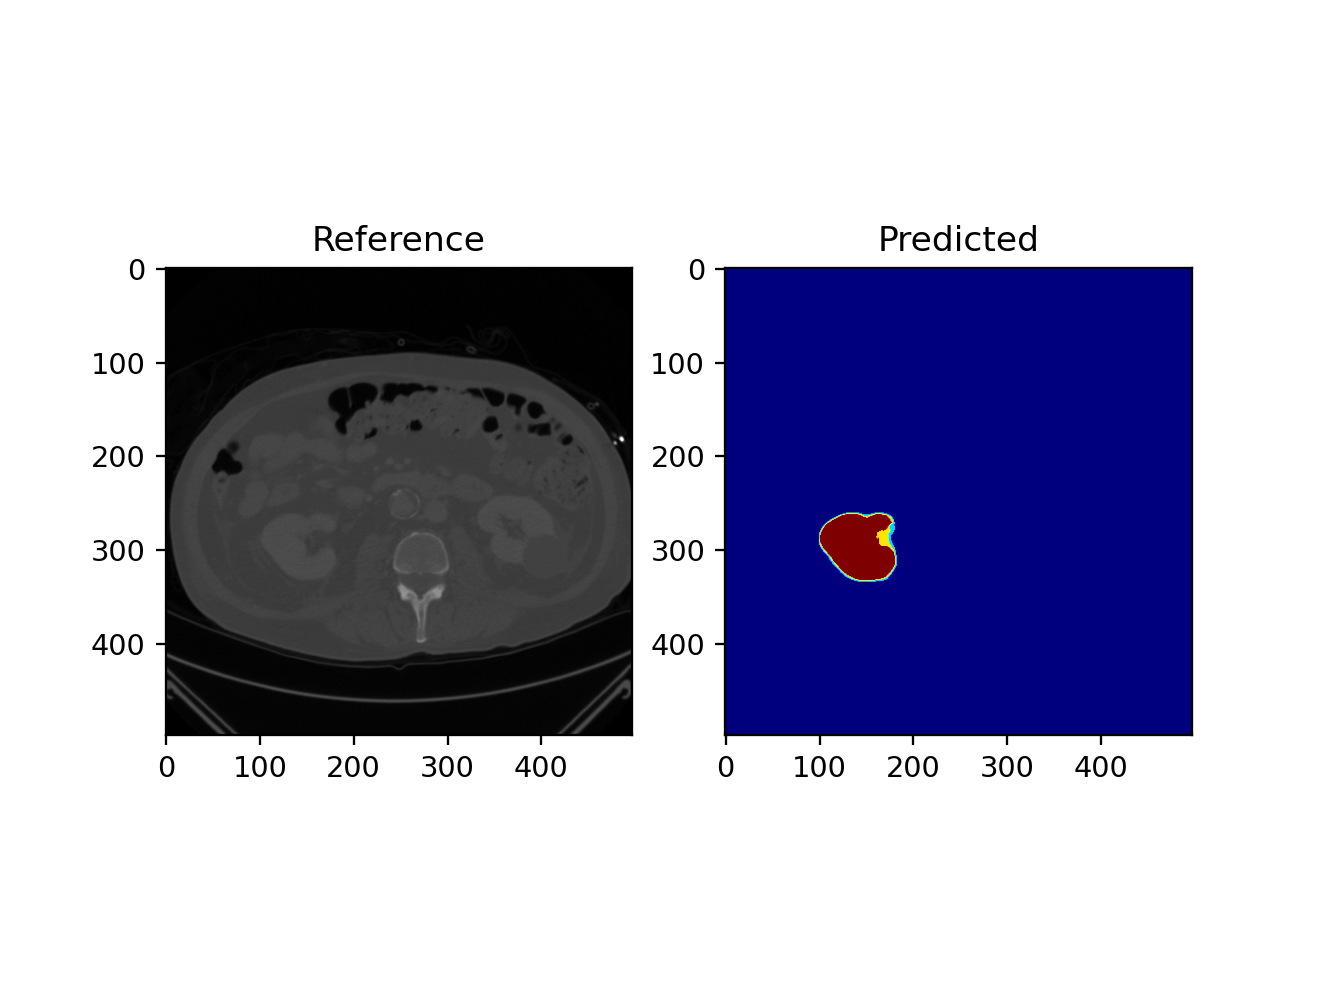

In [7]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(sitk.GetArrayFromImage(src)[0,:,:], cmap='gray')
plt.title('Reference')
plt.subplot(1,2,2)
plt.title('Predicted')
plt.imshow((np.array(data['softmax'][1:,:,:], dtype=np.float32)>0.5).sum(axis=0), cmap='jet')
plt.show()

<IPython.core.display.Javascript object>


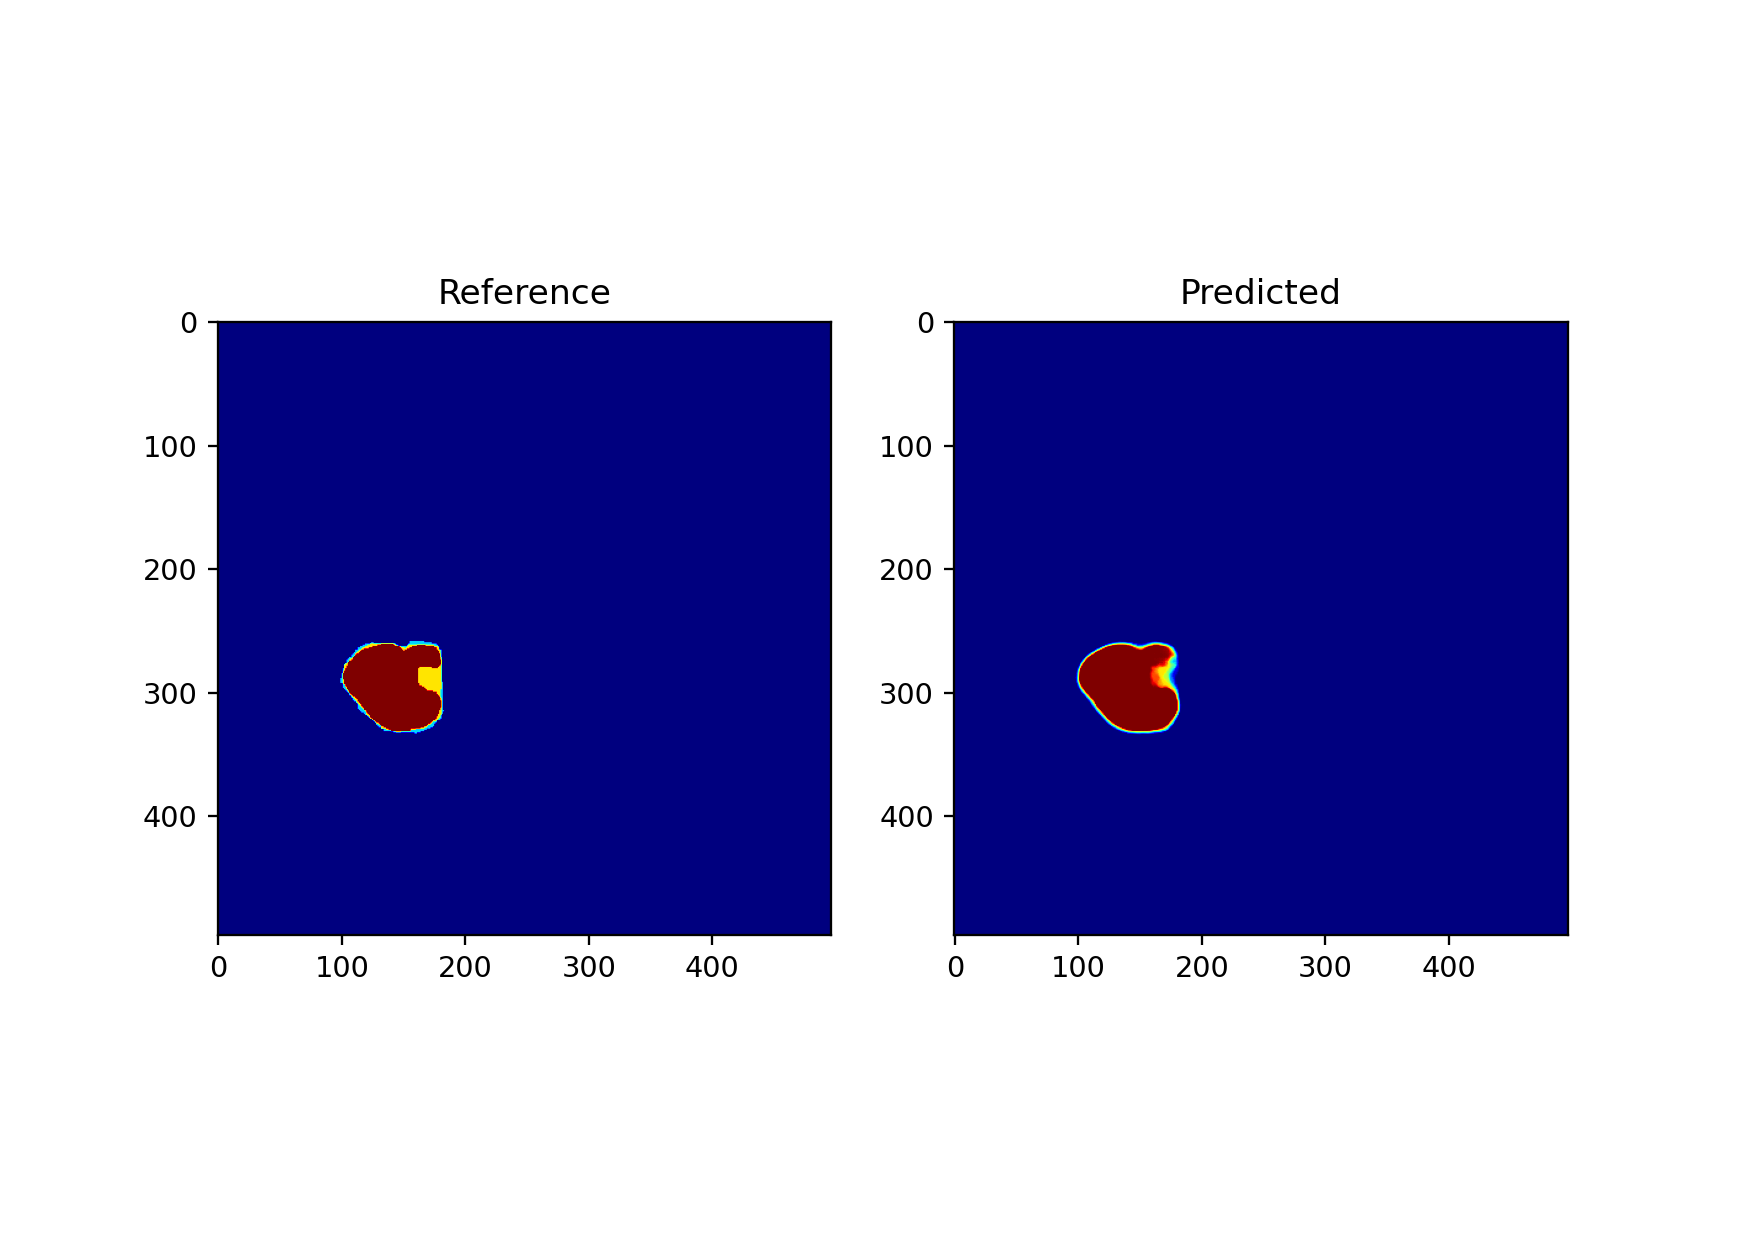

In [9]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(ground_truth, cmap='jet')
plt.title('Reference')
plt.subplot(1,2,2)
plt.title('Predicted')
plt.imshow((np.array(data['softmax'][1:,:,:], dtype=np.float32)).sum(axis=0), cmap='jet')
plt.show()

<IPython.core.display.Javascript object>


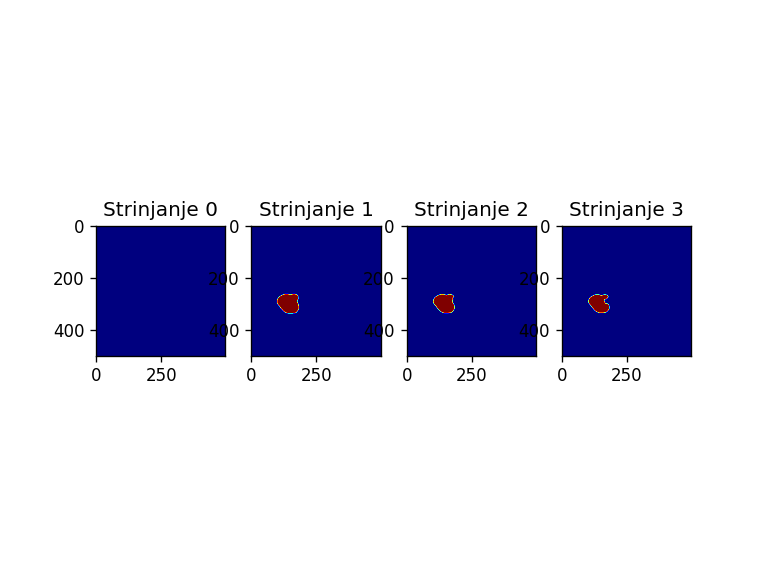

In [9]:
plt.figure()
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(np.array(data['softmax'][i,:,:]>0.5, dtype=np.float32), cmap='jet')
    plt.title('Strinjanje ' + str(i))
plt.show()

In [10]:
def dice(result, reference):
    result = np.atleast_1d(result.astype(np.bool))
    reference = np.atleast_1d(reference.astype(np.bool))
    intersection = np.count_nonzero(result & reference)
    size_i1 = np.count_nonzero(result)
    size_i2 = np.count_nonzero(reference)

    try:
        dc = 2. * intersection / float(size_i1 + size_i2)
    except ZeroDivisionError:
        dc = 0.0
    return dc

def total_dice(ground_truth, predicted):
    prob_threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    tmp = 0
    for idx, th in enumerate(prob_threshold):
        predicted_thr = (predicted > th).astype(np.uint8)
        ground_truth_thr = (ground_truth > th).astype(np.uint8)
        tmp += dice(predicted_thr, ground_truth_thr)
    return tmp/9.0


In [14]:
ground_truth = getAverage('Data/validation_data_v2/kidney/Validation/case21')
predicted= (np.array(data['softmax'][1:,:,:], dtype=np.float32)).sum(axis=0)
print(total_dice(ground_truth, predicted))

0.9482079547947985


In [19]:
cases = os.listdir('/home/mzukovec/Documents/Faks/Semester 3/AMS/Data/validation_data_v2/kidney/Validation')
ground_truths = []
predictions = []

for case in cases:
    ground_truths.append(getAverage('Data/validation_data_v2/kidney/Validation/' + case))
    data = np.load('/home/mzukovec/Documents/Faks/Semester 3/AMS/nnUNet/nnunet/nnUNet_Prediction_Results/Task105_KD1/'+case+'.npz')
    predictions.append((np.array(data['softmax'][1:,:,:], dtype=np.float32)>0.5).sum(axis=0)/3.0)

<IPython.core.display.Javascript object>


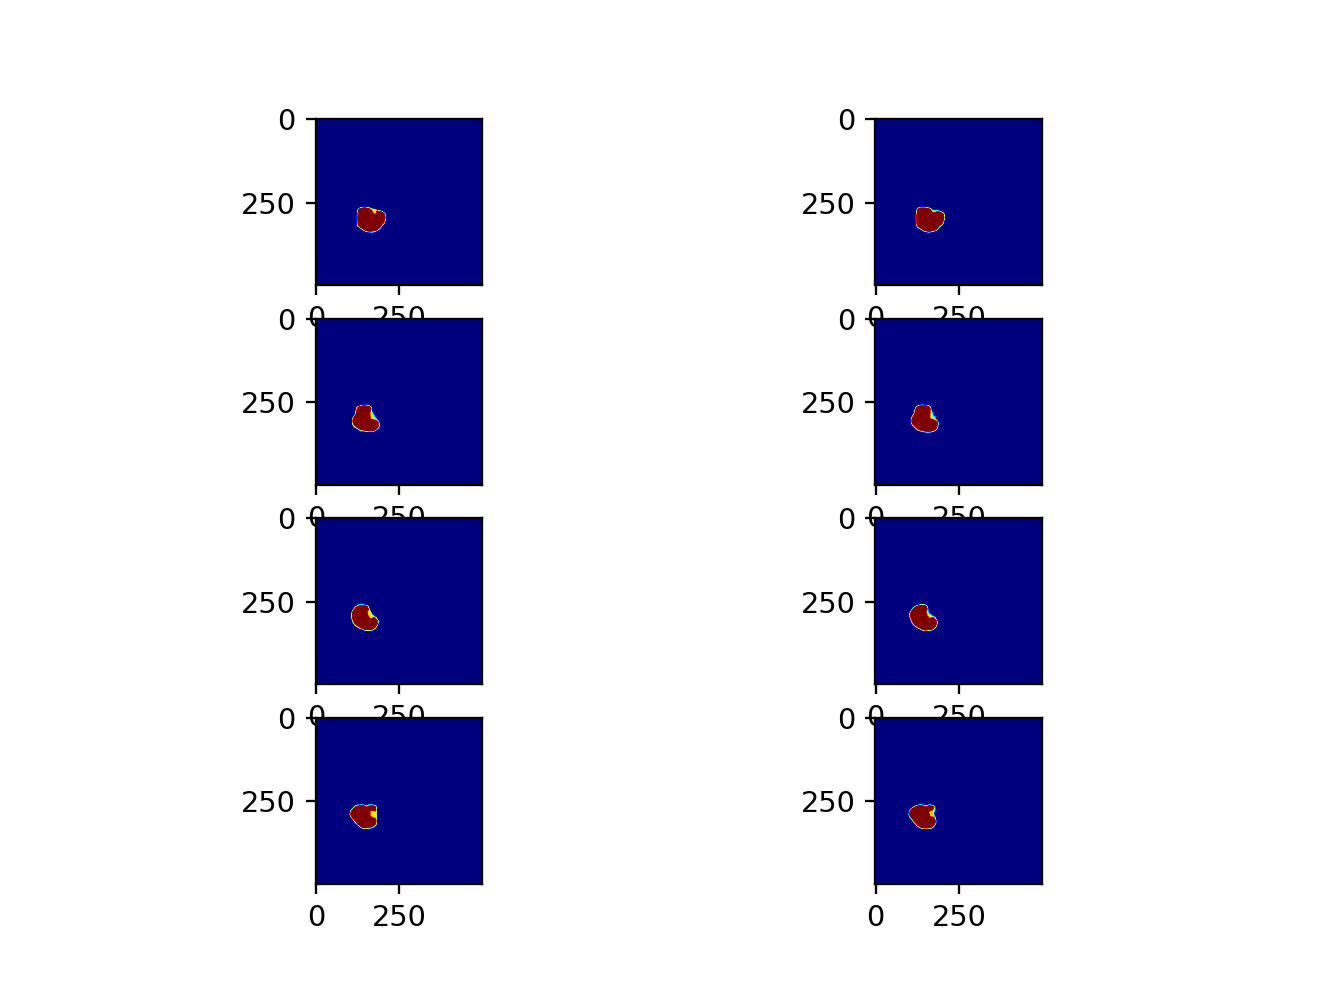

In [20]:
dice_score = []
for i in range(len(ground_truths)):
    dice_score.append(total_dice(ground_truths[i], predictions[i]))

idx = 1
plt.figure()
for i in range(len(ground_truths)):
    plt.subplot(len(ground_truths), 2, idx)
    idx += 1
    plt.imshow(np.array(ground_truths[i], dtype=np.float32), cmap='jet')
    plt.subplot(len(ground_truths), 2, idx)
    idx += 1
    plt.imshow(np.array(predictions[i], dtype=np.float32), cmap='jet')
plt.show()

In [21]:
print('Dice for validation images: ', np.mean(dice_score))

Dice for validation images:  0.9739979317942696


In [22]:
dice_score

[0.9824884003520167,
 0.9731429334899517,
 0.9712295165212671,
 0.9691308768138431]

<IPython.core.display.Javascript object>


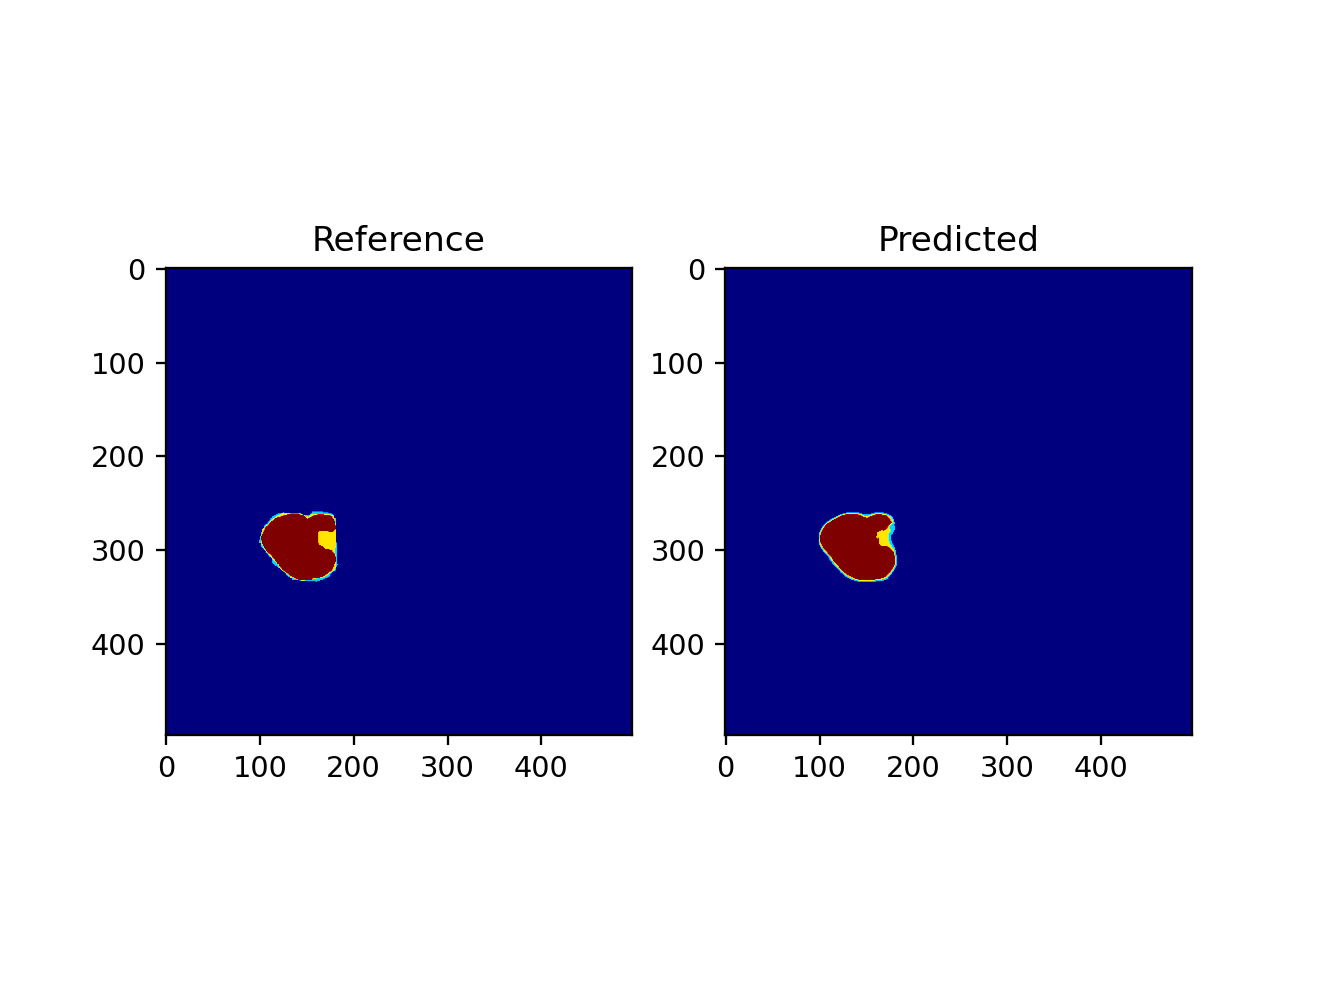

In [23]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(ground_truth, cmap='jet')
plt.title('Reference')
plt.subplot(1,2,2)
plt.title('Predicted')
plt.imshow((np.array(data['softmax'][1:,:,:], dtype=np.float32)>0.5).sum(axis=0), cmap='jet')
plt.show()

<IPython.core.display.Javascript object>


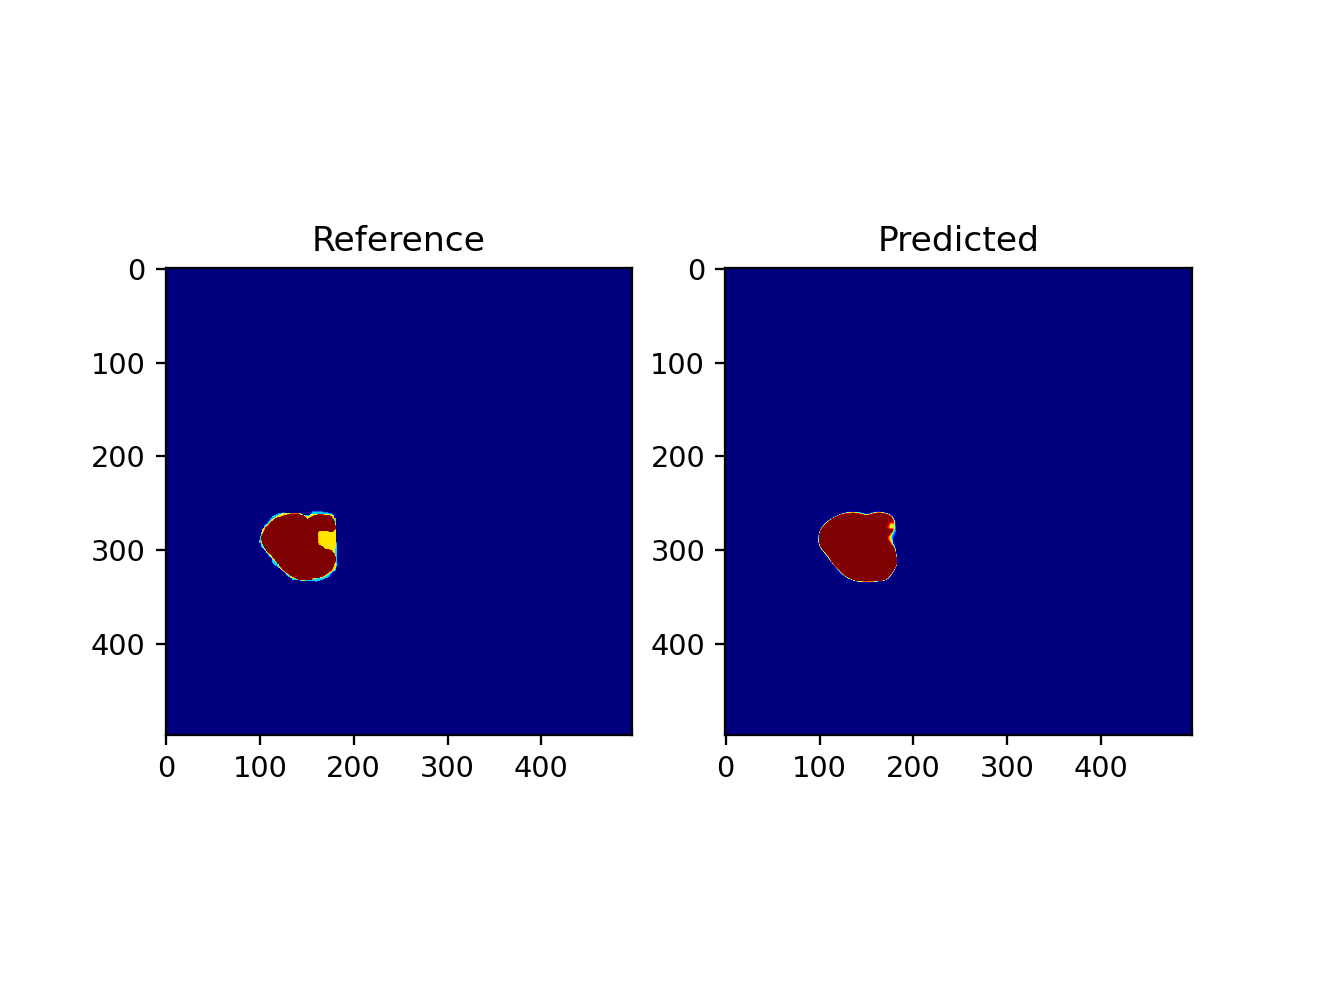

<ufunc 'log'>

In [25]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(ground_truth, cmap='jet')
plt.title('Reference')
plt.subplot(1,2,2)
plt.title('Predicted')
plt.imshow((np.array(data['softmax'][1,:,:], dtype=np.float32)), cmap='jet')
plt.show()
np.log